In [1]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [2]:
import os
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import json

from ml_genn import Network, Population, Connection
from ml_genn.callbacks import SpikeRecorder, VarRecorder
from ml_genn.compilers import InferenceCompiler
from ml_genn.connectivity import Dense
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput
from ml_genn.synapses import Exponential

from ml_genn.utils.data import calc_latest_spike_time
from ml_genn.compilers.event_prop_compiler import default_params

from ml_genn.utils.data import (calc_latest_spike_time, calc_max_spikes,
                                preprocess_tonic_spikes)

In [3]:
# sample ID used for visual
sample_id = 0

In [4]:
# loading parameter values from last successful run
param_dir = "/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/testing_2/params.json"

with open(param_dir, "r") as f:
        params = json.load(f)

In [5]:
# Kaggle dataset directory
dataset = 'https://www.kaggle.com/datasets/thomasshoesmith/spiking-google-speech-commands/data'

# Using opendatasets to download SGSC dataset
od.download(dataset)

x_test = np.load("spiking-google-speech-commands/testing_x_spikes.npy", allow_pickle=True)
y_test = np.load("spiking-google-speech-commands/testing_y_spikes.npy", allow_pickle=True)

# Preprocess
x_test_spikes = []
for i in range(len(x_test)):
    events = x_test[i]
    x_test_spikes.append(preprocess_tonic_spikes(events, 
                                                  x_test[0].dtype.names,
                                                  (params["NUM_INPUT"], 1, 1),
                                                  time_scale = 1))

# Determine max spikes and latest spike time
max_spikes = calc_max_spikes(x_test_spikes)
latest_spike_time = calc_latest_spike_time(x_test_spikes)
print(f"Max spikes {max_spikes}, latest spike time {latest_spike_time}")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/thomasshoesmith/spiking-google-speech-commands


100%|██████████| 118M/118M [00:04<00:00, 26.9MB/s] 



Max spikes 4544, latest spike time 1999


In [6]:
# loading pretrained weights
w_i2h = np.load("SGSC_pretrained_weights/SGSC_Pop0_Pop1-g.npy")
w_i2h = w_i2h.reshape((params["NUM_INPUT"], 
                       params["NUM_HIDDEN"]))

w_h2h = np.load("SGSC_pretrained_weights/SGSC_Pop1_Pop1-g.npy")
w_h2h = w_h2h.reshape((params["NUM_HIDDEN"],
                       params["NUM_HIDDEN"]))

w_h2o = np.load("SGSC_pretrained_weights/SGSC_Pop1_Pop2-g.npy")
w_h2o = w_h2o.reshape((params["NUM_HIDDEN"], 
                       params["NUM_OUTPUT"]))

In [7]:
# change directory for output code of (ML_)GeNN
try:
    os.makedirs("output/" + params["output_dir"] + "_inference_run")
except:
    pass

os.chdir("output/" + params["output_dir"] + "_inference_run")

In [8]:
network = Network(default_params)

with network:
    # Populations
    input = Population(SpikeInput(max_spikes = params["BATCH_SIZE"] * max_spikes),
                       params["NUM_INPUT"],
                       record_spikes=True)
    
    hidden = Population(LeakyIntegrateFire(v_thresh=1.0, 
                                    tau_mem=20.0),
                params.get("NUM_HIDDEN"), 
                record_spikes=True)
    
    output = Population(LeakyIntegrate(tau_mem=20.0, 
                                readout="avg_var_exp_weight"),
                params.get("NUM_OUTPUT"), 
                record_spikes=True)

    Connection(input, hidden, Dense(weight = w_i2h),
                Exponential(2.0))
    
    if params.get("recurrent"):
        Connection(hidden, hidden, Dense(weight = w_h2h),
                Exponential(2.0))
    
    Connection(hidden, output, Dense(w_h2o),
                Exponential(2.0))

compiler = InferenceCompiler(evaluate_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                            reset_in_syn_between_batches=True,
                            #quantise_num_weight_bits=8,
                            #quantise_weight_percentile=99,
                            batch_size = params.get("BATCH_SIZE"))

compiled_net = compiler.compile(network)

with compiled_net:

    callbacks = ["batch_progress_bar",
                 SpikeRecorder(input, 
                               key = "input_spikes",
                               example_filter = sample_id),
                 SpikeRecorder(hidden,
                               key = "hidden_spikes",
                               example_filter = sample_id),
                 VarRecorder(output, 
                             var = "v",
                             key = "output_voltages",
                             example_filter = sample_id)]

    metrics, cb_data = compiled_net.evaluate({input: x_test_spikes},
                                             {output: y_test},
                                             callbacks = callbacks)
    
    #compiled_net.save(("quant8",), serialiser)

    print(f"Accuracy = {100 * metrics[output].result}%")

make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/testing_2_inference_run/InferenceCompiler_CODE'


/its/home/ts468/PhD/ve/genn_5_0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/testing_2_inference_run/InferenceCompiler_CODE'


100%|██████████| 344/344 [00:07<00:00, 48.60it/s, SparseCategoricalAccuracy: 0.7168]

Accuracy = 71.67651067696501%


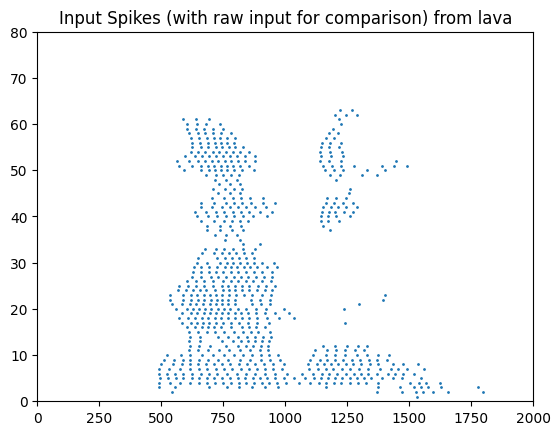

In [9]:
# Input spike activity
plt.scatter(cb_data["input_spikes"][0][0], cb_data["input_spikes"][1][0],
            s = 1)

plt.title('Input Spikes (with raw input for comparison) from lava')
plt.ylim(0, params["NUM_INPUT"])
plt.xlim(0, 2000)
plt.show()

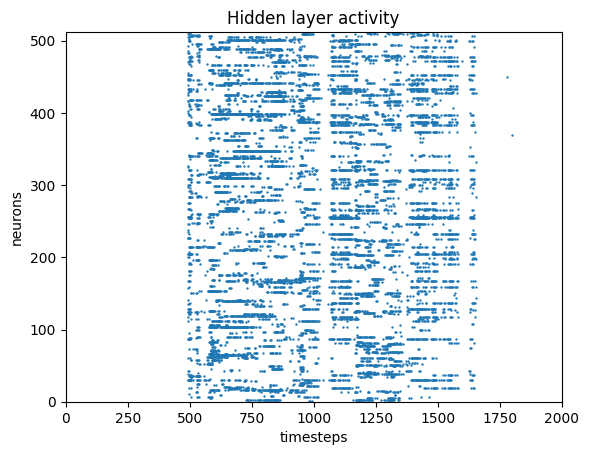

In [10]:
plt.scatter(cb_data["hidden_spikes"][0][0], cb_data["hidden_spikes"][1][0],
            s = 0.5)

plt.ylabel("neurons")
plt.xlabel("timesteps")
plt.title("Hidden layer activity")
plt.ylim(0, params["NUM_HIDDEN"])
plt.xlim(0, 2000)
plt.show()

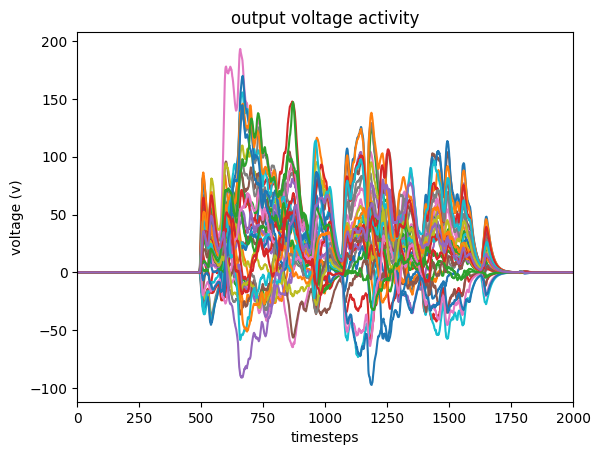

In [11]:
plt.plot(cb_data["output_voltages"][0])

plt.ylabel("voltage (v)")
plt.xlabel("timesteps")
plt.title("output voltage activity")
plt.xlim(0, 2000)
plt.show()